# Imports

In [1]:
import numpy as np
import pandas as pd
from itertools import permutations
from scipy.special import binom
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import get_cmap
from matplotlib.cm import rainbow

# The model-space
The model-space is the set of all possible models for a given problem.
## Example: model-space (4 observations, 2 positives)

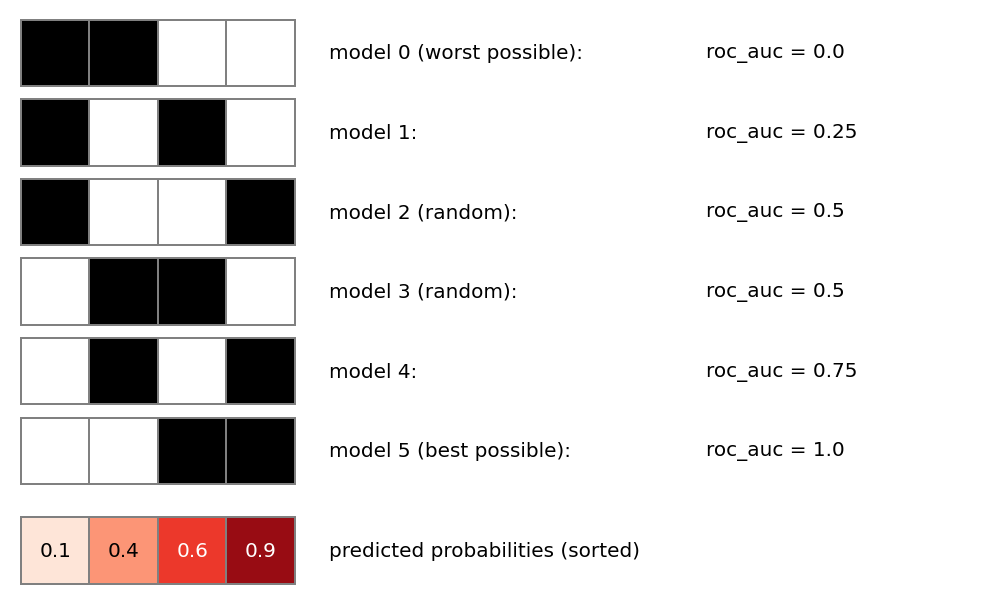

In [2]:
ys = sorted(set(permutations([0,0,1,1])))
probas = np.linspace(.1,.9, 4)

figsize = len(probas) + 10, 1 + .5  + len(ys) + .2 * (len(ys) - 1)
fig,ax = plt.subplots(figsize = figsize)
cmap = get_cmap('Reds')
ax.axis('off')

for i, p in enumerate(probas):
    rect = patches.Rectangle((i,0), 1, 1, lw = 2, edgecolor='grey', facecolor=cmap(p))
    ax.add_patch(rect)
    ax.text(i + .5, .5, round(p, 1), fontsize = 20, color = 'black' if p < .5 else 'white', ha = 'center', va = 'center')
ax.text(len(probas) + .5, .5, 'predicted probabilities (sorted)', fontsize = 20, va ='center')

v = 1.5

for en, y in enumerate(ys):
    for i, p in enumerate(y):
        rect = patches.Rectangle((i,v), 1, 1, lw = 2, edgecolor='grey', facecolor='white' if p == 0 else 'black')
        ax.add_patch(rect)
    roc_auc = roc_auc_score(y,probas)
    model_descr = 'model %s%s:' %(5 - en,' (best possible)' if roc_auc == 1 else ' (worst possible)' if roc_auc == 0 else ' (random)' if roc_auc == .5 else '')
    ax.text(len(y) + .5, v + .5, model_descr, fontsize = 20, va ='center')
    roc_descr = 'roc_auc = %s' % roc_auc        
    ax.text(len(y) + 6, v + .5, roc_descr, fontsize = 20, va ='center')
    v += 1.2

plt.ylim(-.2, figsize[1] + .2)
plt.xlim(-.2, figsize[0] + .2)

plt.tight_layout()
plt.savefig('model_space_4obs.png')

Out of curiosity, how many models do exist in the full model-space, if we take 10_000 observations, 100 of which positives?

In [3]:
binom(10_000, 100)

6.520846924611369e+241

... this is why we need a reduced model-space.
# The reduced model-space
The reduced model-space is a faithful miniature of the full model-space.
It is obtained ensuring that the models' performances are sufficiently diversified and cover all the range from random (roc area = .5) to best possible (roc area = 1).
This is the algorithm for producing the reduced model-space that I propose:

In [4]:
def get_y(n_zeros_head, n_zeros_tail, n_ones_tail):
    len_head = n_zeros_head
    len_tail = n_zeros_tail + n_ones_tail
    head = np.zeros(len_head)
    tail = np.zeros(len_tail)
    tail[[int(x) for x in np.arange(1 / n_ones_tail / 2, 1, 1 / n_ones_tail) * len_tail]] = 1
    y = pd.Series(np.concatenate([head, tail]))
    return y

def get_reduced_model_space(n_zeros, n_ones):
    for n_zeros_head in range(n_zeros + 1):
        y = get_y(n_zeros_head = n_zeros_head, n_zeros_tail = n_zeros - n_zeros_head, n_ones_tail = n_ones)
        yield y

## Example: reduced model-space (10 observations, 4 positives)
Note: if you use the function named "get_reduced_model_space", you will obtain a slightly different figure. Why is that? Just for "didactic" reasons: because the figure "made by hand" is nicer and easier to explain. However, the underlying logic is the same

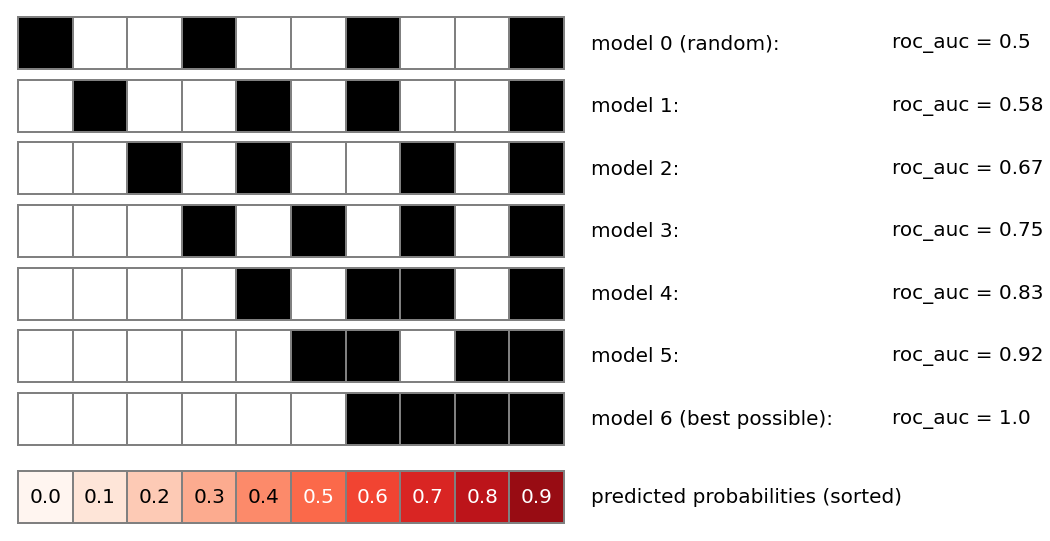

In [5]:
n_pos = 4
n_neg = 6
probas = pd.Series(np.linspace(0, .9, n_pos + n_neg))

fig,ax = plt.subplots()
cmap = get_cmap('Reds')
ax.axis('off')

for i, p in enumerate(probas):
    rect = patches.Rectangle((i,0), 1, 1, lw = 2, edgecolor='grey', facecolor=cmap(p))
    ax.add_patch(rect)
    ax.text(i + .5, .5, round(p, 1), fontsize = 20, color = 'black' if p < .5 else 'white', ha = 'center', va = 'center')
ax.text(len(probas) + .5, .5, 'predicted probabilities (sorted)', fontsize = 20, va ='center')

ys = [
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 0, 1, 1, 0, 1],
    [0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
    [0, 0, 1, 0, 1, 0, 0, 1, 0 ,1],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1]
]

v = 1.5

for e, y in enumerate(ys):
    for i, p in enumerate(y):
        rect = patches.Rectangle((i,v), 1, 1, lw=2, edgecolor='grey', facecolor='white' if p == 0 else 'black')
        ax.add_patch(rect)
    roc_auc = round(roc_auc_score(y,probas),2)
    model_descr = 'model %s%s:' %(6 - e,' (best possible)' if roc_auc == 1 else ' (worst possible)' if roc_auc == 0 else ' (random)' if roc_auc == .5 else '')
    ax.text(len(y) + .5, v + .5, model_descr, fontsize = 20, va ='center')
    roc_descr = 'roc_auc = %s' % roc_auc        
    ax.text(len(y) + 6, v + .5, roc_descr, fontsize = 20, va ='center')
    v += 1.2

figsize = len(probas) + 8, 1 + .5  + len(ys) + .2 * (len(ys) - 1)
fig.set_size_inches(figsize)
plt.ylim(-.2,figsize[1]+.2)
plt.xlim(-.2,figsize[0]+.2)

plt.savefig('model_space_10obs.png')

# Compare ROC-Area and Average-Precision for all the models in the reduced model-space (11k obs, 1k positives)

In [6]:
n_neg = 10_000
n_pos = 1_111
prevalence = n_pos / (n_neg + n_pos)
probas = pd.Series(np.linspace(0, 1, n_pos + n_neg))
subset = probas > 1 - prevalence
n_predpos = subset.sum()

auroc = []
avprec = []

# for each model in the model_space...
for y in get_reduced_model_space(n_zeros = n_neg, n_ones = n_pos):
    # compute area under roc curve and store
    auroc.append( roc_auc_score(y, probas) )
    # compute average precision and store
    avprec.append( average_precision_score(y, probas) )

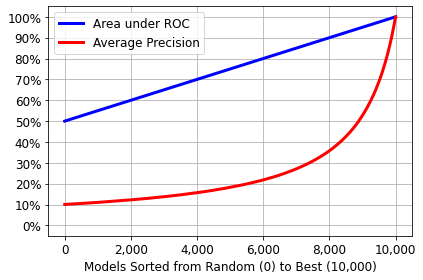

In [7]:
plt.plot(range(len(auroc)), auroc, color = 'blue', lw = 3, label = 'Area under ROC')
plt.plot(range(len(avprec)), avprec, color = 'red', lw = 3, label = 'Average Precision')
plt.yticks(np.linspace(0, 1, 11), ["{0:.0%}".format(x) for x in np.linspace(0, 1, 11)], fontsize = 12)
plt.xticks(np.linspace(0, len(avprec) - 1, 6), ['{:,}'.format(int(x)) for x in np.linspace(0, len(avprec) - 1, 6)], fontsize = 12)
plt.xlabel('Models Sorted from Random (0) to Best (10,000)', fontsize = 12)
plt.ylim(-.05, 1.05)
plt.grid()
plt.legend(loc='upper left', fontsize = 12)
fig.set_size_inches(6,6)
plt.tight_layout()
plt.savefig('auroc_vs_avprec.png', dpi = 300)

## Show where some models would land on each of the 2 curves above

In [8]:
models = {
    0: 'Random',
    6_000: 'Logistic Regression',
    8_000: 'Gradient Boosting',
    8_700: 'Gradient Boosting (optimized)',
    10_000: 'Best (theoretical)'
}

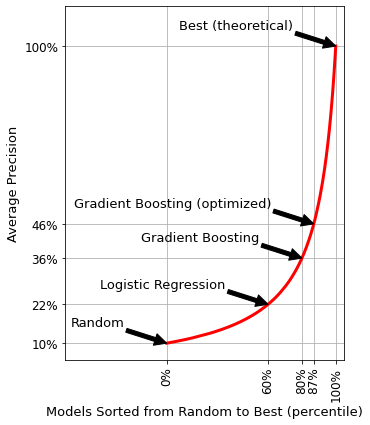

In [9]:
fig, ax = plt.subplots(figsize = (5, 6.5))
ax.plot(range(len(avprec)), avprec, color = 'red', lw = 3, label = 'Average Precision')
ax.set_yticks([avprec[j] for j in models.keys()])
ax.set_yticklabels(['{0:.0%}'.format(avprec[k]) for k in models.keys()])
ax.set_xticks(list(models.keys()))
ax.set_xticklabels(['{0:.0%}'.format(k / 10_000) for k in models.keys()], rotation = 90)
ax.set_ylabel('Average Precision', fontsize = 13)
ax.set_xlabel('Models Sorted from Random to Best (percentile)', fontsize = 13)
ax.set_ylim(.05, 1.12)
ax.set_xlim(-6_000, 10_500)
ax.tick_params(axis='both', which='major', labelsize=12)
for k in models.keys():
    ax.annotate(s=models[k], xy=(k, avprec[k]), xytext=(k - 2_500, avprec[k]+.05), ha = 'right', arrowprops={'fc':'black'}, fontsize = 13)
ax.grid()
plt.savefig('comp_models_ap.png', bbox_inches='tight', dpi = 300)

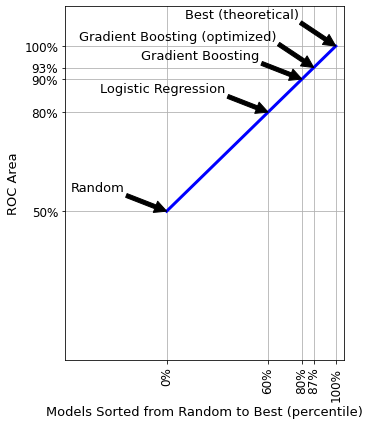

In [10]:
fig, ax = plt.subplots(figsize = (5, 6.5))
ax.plot(range(len(auroc)), auroc, color = 'blue', lw = 3, label = 'ROC Area')
ax.set_yticks([auroc[j] for j in models.keys()])
ax.set_yticklabels(['{0:.0%}'.format(auroc[k]) for k in models.keys()])
ax.set_xticks(list(models.keys()))
ax.set_xticklabels(['{0:.0%}'.format(k / 10_000) for k in models.keys()], rotation = 90)
ax.set_ylabel('ROC Area', fontsize = 13)
ax.set_xlabel('Models Sorted from Random to Best (percentile)', fontsize = 13)
ax.set_ylim(.05, 1.12)
ax.set_xlim(-6_000, 10_500)
ax.tick_params(axis='both', which='major', labelsize=12)
for k in models.keys():
    a = -2_200 if k > 8_000 else -2_500
    b = .075 if k > 8_000 else .05
    ax.annotate(s=models[k], xy=(k, auroc[k]), xytext=(k + a, auroc[k]+b), va = 'bottom', ha = 'right', arrowprops={'fc':'black'}, fontsize = 13)
ax.grid()
plt.savefig('comp_models_roc.png', bbox_inches='tight', dpi = 300)

# Compare Average-Precision for all the models in the reduced model-space for different levels of prevalence

In [11]:
# the number of positives will be fixed so that we have the same number of models for every problem
n_neg = 10_000
avprec_dct = dict()

# for different levels of prevalence...
for prevalence in [.5, .4, .3, .2, .1, .05, .01]:
    
    n = int(round(n_neg / (1 - prevalence)))
    n_pos = n - n_neg
    probas = pd.Series(np.linspace(0, 1, n))
    avprec_dct[prevalence] = []
    
    # for each model in the reduced model-space...
    for y in get_reduced_model_space(n_zeros = n_neg, n_ones = n_pos):
        # ... compute average precision of current y and store
        avprec_dct[prevalence].append( average_precision_score(y, probas) )

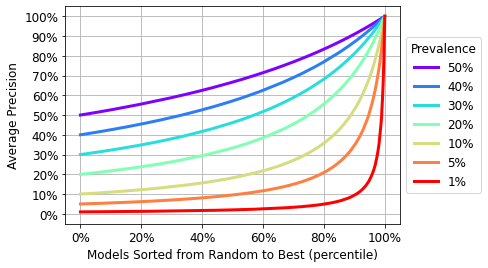

In [12]:
for prevalence, color in zip(avprec_dct.keys(),rainbow(np.linspace(0, 1, len(avprec_dct)))):
    plt.plot(range(len(avprec_dct[prevalence])), avprec_dct[prevalence], color = color, lw = 3, label = "{0:.0%}".format(prevalence))
plt.yticks(np.linspace(0, 1, 11), ['{0:.0%}'.format(x) for x in np.linspace(0, 1, 11)], fontsize = 12)
plt.xticks(np.linspace(0, len(avprec_dct[prevalence]), 6), ['{0:.0%}'.format(x / 10_000) for x in np.linspace(0, len(avprec_dct[prevalence]), 6)], fontsize = 12)
plt.ylim(-.05, 1.05)
plt.ylabel('Average Precision', fontsize = 12)
plt.xlabel('Models Sorted from Random to Best (percentile)', fontsize = 12)
plt.grid()
plt.legend(title = 'Prevalence', loc = 'center left', bbox_to_anchor = (1, 0.5), fontsize = 12, title_fontsize = 12)
plt.savefig('avprec_by_prevalence.png', bbox_inches="tight", dpi = 300)

In [ ]:
### end ###